Instructions
Load the dataset into pandas dataframe.  
Perform data cleaning and preprocessing as necessary.  
Split the data into training and testing sets using an 80:20 ratio.  
Scale the data using StandardScaler.  
Build an ANN classification model.  
Experiment with different model architectures, activation functions, regularization techniques, learning rates, and batch sizes to optimize the model's performance.  
Evaluate the model's performance using accuracy, precision, recall, F1 score, and ROC AUC score as the metrics.  
Interpret the results and draw conclusions about the factors that are most important in predicting whether a user will click on an online ad.   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import ast
import tensorflow as tf
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score,recall_score,precision_score, roc_auc_score, accuracy_score

In [233]:
# 1. Load the dataset
df = pd.read_csv('M2-Advertising Dataset.csv')
pd.set_option('display.max_columns', None)
display(df.head())

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [26]:
# Perform data cleaning and preprocessing as necessary.  
print(df.isnull().sum())
print(df.dtypes)

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64
Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Male                          int64
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object


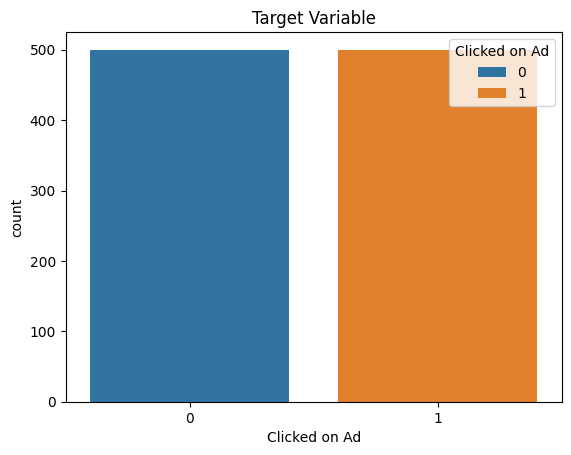

In [11]:
sns.countplot(data = df , x ='Clicked on Ad', hue = 'Clicked on Ad')
plt.title('Target Variable')
plt.show()

In [ ]:
# 2. Data Preprocessing and cleaning
X = df.drop(columns='Clicked on Ad', axis= 1)
y = df['Clicked on Ad']

#Encoding Categorical Variable Gender
LE1 = LabelEncoder()
X['Country'] = np.array(LE1.fit_transform(X['Country']))
X['City'] = np.array(LE1.fit_transform(X['City']))

# Converting Timestamp to datetime
X['Timestamp'] = pd.to_datetime(X['Timestamp'])
X['year'] = X['Timestamp'].dt.year
X['month'] = X['Timestamp'].dt.month
X['day'] = X['Timestamp'].dt.day
X['hour'] = X['Timestamp'].dt.hour
X['minute'] = X['Timestamp'].dt.minute
X['second'] = X['Timestamp'].dt.second
# Drop the original timestamp column if it's no longer needed
X.drop('Timestamp', axis=1, inplace=True)
display(X.head())

In [ ]:
def process_text_with_tf(text_column):
    articles_dataset = tf.data.Dataset.from_tensor_slices(text_column.values)
    
    # Define TextVectorization layer with custom standardization
    max_features = 10000  # Adjust based on your vocabulary size
    sequence_length = 100  # Adjust based on the length of your documents
    
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length,
        standardize=clean_text
    )
    
    # Adapt the TextVectorization layer to the dataset
    vectorize_layer.adapt(articles_dataset.batch(64))
    
    # Vectorize the articles
    vectorized_articles = articles_dataset.map(lambda x: vectorize_layer(x))
    return vectorized_articles

def clean_text(input_text):
    # Lowercasing
    lowercase_text = tf.strings.lower(input_text)
    # Removing HTML tags
    stripped_html = tf.strings.regex_replace(lowercase_text, "<[^>]+>", " ")
    # Removing URLs
    stripped_urls = tf.strings.regex_replace(stripped_html, r"http\S+", " ")
    # Removing non-alphabetic characters
    stripped_non_alpha = tf.strings.regex_replace(stripped_urls, r"[^A-Za-z]+", " ")

    # tokenized = nltk.word_tokenize(stripped_non_alpha)
    # stop_words = set(stopwords.words('english'))
    # filtered_sentence = [w for w in tokenized if not w in stop_words]
    # clean_str = ' '.join(filtered_sentence)

    return stripped_non_alpha

# returns a dataset of vectorized text
text_column = X.pop('Ad Topic Line')
vect_df = process_text_with_tf(text_column)


# 4. Scale the data using StandardScaler.  
scaler = StandardScaler()
numerical_columns = X.columns 
scaled_numerical_data = scaler.fit_transform(X[numerical_columns])
# Convert the scaled numerical data back to a dataframe
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)
vectorized_articles_numpy = np.array(list(vect_df.as_numpy_iterator()))

In [216]:
# 3. Split the data into training and testing sets
X_train_num, X_test_num, y_train_text, y_test_text, y_train, y_test = train_test_split(
    scaled_numerical_df, vectorized_articles_numpy, y, test_size=0.2, random_state=42
)

# Convert the split datasets to TensorFlow datasets
train_num_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train_num))
test_num_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test_num))
train_text_dataset = tf.data.Dataset.from_tensor_slices(np.array(y_train_text))
test_text_dataset = tf.data.Dataset.from_tensor_slices(np.array(y_test_text))
train_target_dataset = tf.data.Dataset.from_tensor_slices(np.array(y_train))
test_target_dataset = tf.data.Dataset.from_tensor_slices(np.array(y_test))

# Combine the numerical and text datasets with the target variable for training and testing
train_dataset = tf.data.Dataset.zip(((train_num_dataset, train_text_dataset), train_target_dataset))
test_dataset = tf.data.Dataset.zip(((test_num_dataset, test_text_dataset), test_target_dataset))

In [217]:

# 5 and 6. build a neural network model using the tf keras Sequential
def build_model(input_shape_num, input_shape_text, output_shape):
    # Define numerical input
    input_num = tf.keras.layers.Input(shape=(input_shape_num,))
    
    # Define text input
    input_text = tf.keras.layers.Input(shape=(input_shape_text,))
    
    # Process numerical input
    x_num = tf.keras.layers.Dense(32, activation='relu')(input_num)
    
    # Process text input
    x_text = tf.keras.layers.Embedding(input_dim=10000, output_dim=64)(input_text)
    x_text = tf.keras.layers.GlobalAveragePooling1D()(x_text)
    
    # Concatenate processed numerical and text inputs
    concatenated = tf.keras.layers.concatenate([x_num, x_text])
    
    # Add a fully connected layer
    x = tf.keras.layers.Dense(64, activation='relu')(concatenated)
    
    # Output layer
    output = tf.keras.layers.Dense(output_shape, activation='sigmoid')(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[input_num, input_text], outputs=output)
    
    return model

# Compile the model
input_shape_num = X_train_num.shape[1]  # Number of numerical features
input_shape_text = y_train_text.shape[1]  # Length of the text sequence
ann = build_model(input_shape_num, input_shape_text, 1)
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

# Train the model
ann.fit(train_dataset.batch(32), epochs=20, validation_data=test_dataset.batch(32))

print("Model Training Complete!")

Epoch 1/20


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6338 - loss: 0.6493 - val_accuracy: 0.8900 - val_loss: 0.4587
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.3791 - val_accuracy: 0.9200 - val_loss: 0.2758
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9612 - loss: 0.2036 - val_accuracy: 0.9400 - val_loss: 0.1830
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.1251 - val_accuracy: 0.9350 - val_loss: 0.1525
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.0950 - val_accuracy: 0.9450 - val_loss: 0.1451
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0809 - val_accuracy: 0.9450 - val_loss: 0.1438
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0728 - val_accuracy: 0.9450 - val_loss: 0.1464
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.0670 - val_accuracy: 0.9500 - val_loss: 0.1494
Epo

In [227]:
# Experiment with different model architectures, activation functions, regularization techniques, learning rates, and batch sizes to optimize the model's performance.  

# Make predictions
predictions = ann.predict(test_dataset.batch(32))
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


2024-07-08 22:33:44.133184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


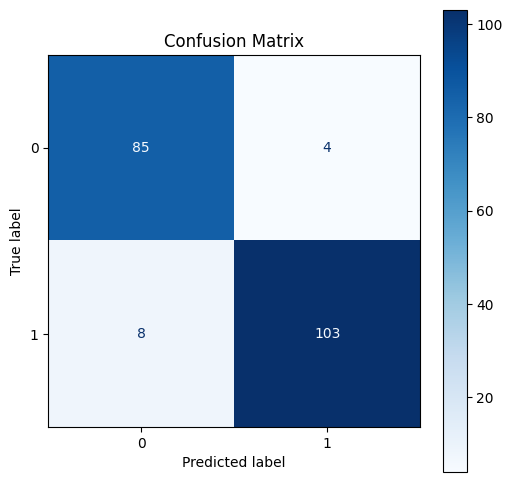

Accuracy: 0.94
Precision: 0.96
Recall : 0.93
F1 Score: 0.94
AUC Score: 0.9414920538516043
False Positive Rate (Type I Error): 0.04
False Negative Rate (Type II Error): 0.07


In [232]:
# 7. Evaluate the model's performance using accuracy, precision, recall, F1 score, and ROC AUC score as the metrics.  
def metrics(y_test, predictions, is_validation=False):
    '''
    This function takes in the testing/validation set and the predictions made by the algorithm, calculates the metrics, and
    plots the confusion matrix to evaluate the performance of the classifier. The color of the confusion matrix changes
    based on whether it's a validation set.
    '''

    conf_mtrx = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = 'YlOrBr' if is_validation else 'Blues'
    disp.plot(cmap=cmap, include_values=True, ax=ax)
    plt.title('Confusion Matrix' + (' (Validation Set)' if is_validation else ''))
    plt.show()

    print(f'Accuracy: {round(accuracy_score(y_test, predictions), 2)}')
    print(f'Precision: {round(precision_score(y_test, predictions), 2)}')
    print(f'Recall : {round(recall_score(y_test, predictions), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, predictions), 2)}')
    print(f'AUC Score: {roc_auc_score(y_test, predictions)}')


    # Error calculation, since these are often more interpretable to a general audience
    tn, fp, fn, tp = conf_mtrx.ravel()
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    print(f'False Positive Rate (Type I Error): {round(false_positive_rate, 2)}')
    print(f'False Negative Rate (Type II Error): {round(false_negative_rate, 2)}')

y_test = np.array(list(test_target_dataset.as_numpy_iterator()))
metrics(y_test, predictions, is_validation=False)

# 8. Conclusion

Model results look great considering there was a mix of numerical, categorial, and vector data. The model was able to predict with 94% accuracy, 96% precision, 93% recall, and 94% F1 score. The model was able to predict whether a user will click on an online ad based on the given factors. My initial reaction is that all the features provide some quality information since the model was trained on all of it together. Standarizing some of the fields like timestamp or their converted values may have not been neccessary since the model was able to predict with high accuracy. I believe by keeping the a mix of the text and numerical data, the model was able to learn the patterns in the data.